# Recurrent Neural Networks    

First, we make a class definition with all appropriate functions that will be useful. 

Almost everything comes from here: http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-2-implementing-a-language-model-rnn-with-python-numpy-and-theano/

Changed very few things from implementation here. Mostly names to fit with what we're doing here, and so that I can understand it. Generalized some formulas so that I'm not tied down to input data being one-hot encoded vectors. I see why they did it, so you don't have to multiply the entire matrix, but I can see cases where I'm going to want to combine inputs, which doesn't make sense in the language model that they are using. But it does for me. I also defined RNN module with this class definition so in the future I can just import it like anything else.  

In [1]:
import itertools
import operator
import numpy as np
import sys
import os
import time
from datetime import datetime

class behaviorRNN:
     
    def __init__(self, noFeatures = 2, hidden_dim=100, bptt_truncate=4):
        # Assign instance variables
        self.noFeatures = noFeatures 
        self.hidden_dim = hidden_dim
        self.bptt_truncate = bptt_truncate
        # Randomly initialize network parameters between 1/sqrt()
        f = lambda x,y: y * np.sqrt(1./x)
        
        self.Wxh = np.random.uniform(f(noFeatures, -1), f(noFeatures, 1), (hidden_dim, noFeatures))
        self.Why = np.random.uniform(f(hidden_dim, -1), f(hidden_dim, 1), (noFeatures, hidden_dim))
        self.Whh = np.random.uniform(f(hidden_dim, -1), f(hidden_dim, 1), (hidden_dim, hidden_dim))
        
    def softmax(self, x):  
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0)  
    
     
    def predict(self, seq):
        p, h  = self.forward_propagation(seq)
        #max of last prediction
        return np.argmax(p, axis=1)
    
    
    def forward_propagation(self, seq):
        #seq is 1-dimensional not one-hot vector
        noTrials = len(seq)
        #this is the hidden 'space'
        h = np.zeros([1 + noTrials, self.hidden_dim])
        #this is the output - probability of next element in sequence
        p = np.zeros([noTrials, self.noFeatures])
        
        for trial in range(noTrials):
            h[trial] = np.tanh(self.Wxh[:, seq[trial]] + self.Whh.dot(h[trial - 1]))
            p[trial] = self.softmax(self.Why.dot(h[trial]))
        return p, h

    
    def calculate_total_loss(self, x, y):
        L = 0
        # For each sequence of trials...
        for i in np.arange(len(y)):
            p, h = self.forward_propagation(x[i])
            # We only care about our prediction of the "correct" words
            correct_trial_predictions = p[np.arange(len(y[i])), y[i]]
            # Add to the loss based on how off we were
            L += -1 * np.sum(np.log(correct_trial_predictions))
        return L

    def calculate_loss(self, x, y):
        # Divide the total loss by the number of training examples
        N = np.sum((len(y_i) for y_i in y))
        return self.calculate_total_loss(x, y) / N


    def bptt(self, x, y, verbose = 0):
        #x and y are NOT one-hot vectors, also they are a single example
        
        noTrials = len(y)
        
        # forward propagation
        p, h = self.forward_propagation(x)
        
        # We accumulate the gradients in these variables
        dLdWxh = np.zeros(self.Wxh.shape)
        dLdWhh = np.zeros(self.Whh.shape)
        dLdWhy = np.zeros(self.Why.shape)
        
        #difference between prediction and labels
        delta_p = p
        delta_p[np.arange(noTrials), y] -= 1.

        # For each output backwards...
        for trial in np.arange(noTrials)[::-1]:
            
            #easiest case
            dLdWhy += np.outer(delta_p[trial], h[trial].T)
            
            # Initial delta calculation
            delta_t = self.Why.T.dot(delta_p[trial]) * (1 - (h[trial] ** 2))
            # Backpropagation through time (for at most self.bptt_truncate steps)
            for bptt_step in np.arange(max(0, trial - self.bptt_truncate), trial + 1)[::-1]:
                #for debugging
                #if verbose: print "Backpropagation step t=%d bptt step=%d " %(trial, bptt_step)
                dLdWhh += np.outer(delta_t, h[bptt_step - 1])         
                dLdWxh[:, x[bptt_step]] += delta_t
                # Update delta for next step
                delta_t = self.Whh.T.dot(delta_t) * (1 - h[bptt_step - 1] ** 2)
        return [dLdWxh, dLdWhh, dLdWhy]


    
    def gradient_check(self, x, y, delta = 0.001, error_threshold = 0.01):
        
        #i hope this fixes the issues, bro - it did!
        self.bptt_truncate = 1000
        
        # Calculate the gradients using backpropagation. We want to checker if these are correct.
        bptt_gradients = self.bptt(x, y)
        # List of all parameters we want to check.
        model_parameters = ['Wxh', 'Whh', 'Why']
        # Gradient check for each parameter
        for pidx, pname in enumerate(model_parameters):
            # Get the actual parameter value from the mode, e.g. model.W
            parameter = operator.attrgetter(pname)(self)
            print "Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape))
            # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
            it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
            while not it.finished:
                ix = it.multi_index
                # Save the original value so we can reset it later
                original_value = parameter[ix]
                # Estimate the gradient using (f(x+delta) - f(x-delta))/(2*delta)
                parameter[ix] = original_value + delta
                gradplus = self.calculate_total_loss([x], [y])
                parameter[ix] = original_value - delta
                gradminus = self.calculate_total_loss([x], [y])
                estimated_gradient = (gradplus - gradminus) / (2 * delta)
                # Reset parameter to original value
                parameter[ix] = original_value
                # The gradient for this parameter calculated using backpropagation
                backprop_gradient = bptt_gradients[pidx][ix] 
                # calculate The relative error: (|x - y|/(|x| + |y|))
                relative_error = np.abs(backprop_gradient - estimated_gradient) \
                                / (np.abs(backprop_gradient) + np.abs(estimated_gradient))
                # If the error is too large -> fail the gradient check
                if relative_error > error_threshold:
                    print "Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix)
                    print "+h Loss: %f" % gradplus
                    print "-h Loss: %f" % gradminus
                    print "Estimated_gradient: %f" % estimated_gradient
                    print "Backpropagation gradient: %f" % backprop_gradient
                    print "Relative Error: %f" % relative_error
                    return 
                it.iternext()
            print "Gradient check for parameter %s passed." % (pname)
            
            



    def numpy_sdg_step(self, x, y, learning_rate):
        # Calculate the gradients
        dLdWxh, dLdWhh, dLdWhy = self.bptt(x, y)
        # Change parameters according to gradients and learning rate
        self.Wxh -= learning_rate * dLdWxh
        self.Why -= learning_rate * dLdWhy
        self.Whh -= learning_rate * dLdWhh
        
    def train_with_sgd(model, X_train, y_train, learning_rate=0.005, nepoch=100, evaluate_loss_after=5):
        # We keep track of the losses so we can plot them later
        losses = []
        num_examples_seen = 0
        for epoch in range(nepoch):
            # Optionally evaluate the loss
            if (epoch % evaluate_loss_after == 0):
                loss = model.calculate_loss(X_train, y_train)
                losses.append((num_examples_seen, loss))
                time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                print "%s: Loss after num_examples_seen=%d epoch=%d: %f" \
                                    %(time, num_examples_seen, epoch, loss)
                # Adjust the learning rate if loss increases
                if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                    learning_rate = learning_rate * 0.5 
                    print "Setting learning rate to %f" % learning_rate
                sys.stdout.flush()
            # For each training example...
            for i in range(len(y_train)):
                # One SGD step
                model.numpy_sdg_step(X_train[i], y_train[i], learning_rate)
                num_examples_seen += 1
 


## Data Preparation

Our data consists of sequences of 0's and 1's, which mean EAST or WEST responses made by the rats. The aim, ultimately, is to decode these choices. However, there are a few choices to make as to how to prepare the data. For example, we can:  

1) define sequences of 0's and 1's to denote EAST and WEST choices, or  
2) define sequences of [0,1,2,3], where 0 = EAST and NO REWARD, 1 = EAST AND REWARD, 2 = WEST AND NO REWARD, 3 = WEST AND REWARD  

Furthermore, how to define sequence length ? We can keep each session as a different sequence, in which case the RNN will only have 10 - 40 really long training examples. From what I can understand, RNNs struggle to learn long sequences and need lots of data to do so, so perhaps having fery vew really long sequences will mean the RNN is not able to learn properly. Alternatively, we could "cut up" each session into chunks of ~20 trials and feed them as individual training examples. We also need to add a 'token' that denotes the start of the session. This section will prepare all these options. We will probably try all of them.  

Below are shown the methods used to obtain the data, I did it elsewhere and saved it all to a target folder though. 

In [2]:

def fileName_label(fileName):
    datasetFile = fileName[-fileName[::-1].find('/'):]
    datasetFile = datasetFile[:datasetFile.find('.')]
    a = datasetFile[:datasetFile.find('_')]
    b = datasetFile[-datasetFile[::-1].find('_'):]
    return a+b

def separate_by_session(df):
    sessions = df.groupby(axis=0, level = 'session')
    x = []; y = []
    for label, sess in sessions:
        x_, y_ = sequence_to_xy(sess.values)
        x.append(x_)
        y.append(y_)

    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

def split_sessions(x, y, mu = 20, sigma = 7, min_seq_length = 7):
    new_x = []; new_y = []
    for session_x, session_y in zip(x, y):
        k_old = 0
        finished = 0
        noTrials = len(session_x)
        while finished == 0:
            #sample length of sequence from normal distribution
            k_new = k_old + \
                max(min_seq_length, int(np.floor(np.random.normal(mu, sigma))))

            new_x.append(session_x[k_old: k_old + k_new])
            new_y.append(session_y[k_old: k_old + k_new])
            #shifting index
            k_old = k_new

            if noTrials - k_old < mu:
                finished = 1
                #still want to keep min sequence legnth requirements
                #otherwise little chunk of data gets thrown out :'(
                if (noTrials - k_old) > min_seq_length:
                    new_x.append(session_x[k_old:])
                    new_y.append(session_y[k_old:])

    return new_x, new_y


def sequence_to_xy(seq):
    return seq[:-1], seq[1:]

def add_start_token(seq, start_token):
    #adding start token to each session
    sessions = seq.groupby(axis = 0, level = 'session')
    mod = sessions.get_group('S0')
    mod.loc[pd.IndexSlice['S0', 'B1', -1]] = start_token
    for label, sess in sessions:
        if label != 'S0':
            sess.loc[pd.IndexSlice[label, 'B1', -1]] = start_token
            mod = pd.concat([mod, sess], axis=0)
    mod.sort_index(axis=0, inplace = True)
    return mod



def dataframe_to_sequences(fileName, target):
    #loading data
    df = pickle.load(open(fileName, 'rb'))

    #changing var to int type
    choice_only = df['choice', 0].astype('int64')
    #appending start token
    choice_only = add_start_token(choice_only, 2)

    #including reward information
    choice_reward = df['choice',0] * 2 + df['reward',0]
    choice_reward = choice_reward.astype('int64')
    choice_reward = add_start_token(choice_reward, 4)

    seq_type = {'choice_only': choice_only, 'choice_reward': choice_reward}

    for sequence_option in seq_type.keys():
        input_sequence = seq_type[sequence_option]
        #each sequence is a session
        x, y = separate_by_session(input_sequence)
        #each sequence is of length drawn from normal(mu = 20, sigma= 7)
        x2, y2 = split_sessions(x, y, mu = 20, sigma = 7, min_seq_length = 7)

        file = fileName_label(fileName)
        pickle.dump([x,y],
                    open(target + file + '_' + \
                    sequence_option + '_session_sequences.p', 'wb'))
        pickle.dump([x2, y2],
                    open(target + file + '_' + \
                    sequence_option + '_split_sequences.p', 'wb'))
    return

def split_sequences_train_test(x, y, test_size = 0.2, random_state = 17):
    noSequences = len(x)
    index = np.arange(noSequences)
    
    np.random.seed(random_state)
    np.random.shuffle(index)
    
    cutoff = int(np.floor(noSequences * (1 - test_size)))
    x_train = x[index[:cutoff]]
    y_train = y[index[:cutoff]]
    x_test = x[index[cutoff:]]
    y_test = y[index[cutoff:]]
    
    return x_train, y_train, x_test, y_test
    


## Gradient and Entropy Checks

Let's insantiate an RNN and make some checks. We will check if the cross-entropy is being calculated properly given the random initialization of the weight matrices Wxh, Whh, Why. We will also check if back propagation thru time was implemented properly by calculating all the gradients by shifting them by a small delta. We will also check whether all our datasets are compatible with the pipeline. This may take a while, but it's important ?

In [ ]:
def checks_RNN(RNN, x, y):
    print 'expected cross-entropy: %f' %np.log(1 + np.max(x[0]))
    print 'actual cross-entropy: %f' %RNN.calculate_loss(x, y)    
    #expensive, so only do one example
    RNN.gradient_check(x[0], y[0])
    return


In [524]:

target = ROOT + '/DATA_structures/RNN_sequences/'

for sequences in os.listdir(target):
    print sequences
    x, y = pickle.load(open(target + sequences, 'rb'))
    elements_in_seq = np.max(x[0]) + 1
    #initialize RNN
    RNN = behaviorRNN(noFeatures = elements_in_seq, hidden_dim = 100, bptt_truncate = 4)
    checks_RNN(RNN, x, y)
    print '*' * 80


DSROFC_choice_only_session_sequences.p
expected cross-entropy: 1.098612
actual cross-entropy: 1.155486
Performing gradient check for parameter Wxh with size 300.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 300.
Gradient check for parameter Why passed.
********************************************************************************
DSRSaline_choice_reward_split_sequences.p
expected cross-entropy: 1.609438
actual cross-entropy: 1.572173
Performing gradient check for parameter Wxh with size 500.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 500.
Gradient check for parameter Why passed.
********************************************************************************
PSRMidTraining_choice_rew

Gradient check for parameter Why passed.
********************************************************************************
DSRSaline_choice_only_split_sequences.p
expected cross-entropy: 1.098612
actual cross-entropy: 1.171944
Performing gradient check for parameter Wxh with size 300.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 300.
Gradient check for parameter Why passed.
********************************************************************************
PSRFirstTraining_choice_only_split_sequences.p
expected cross-entropy: 1.098612
actual cross-entropy: 1.167647
Performing gradient check for parameter Wxh with size 300.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 300.
Gradient check for 

Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 300.
Gradient check for parameter Why passed.
********************************************************************************
PSRSaline_choice_reward_session_sequences.p
expected cross-entropy: 1.609438
actual cross-entropy: 1.624982
Performing gradient check for parameter Wxh with size 500.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 500.
Gradient check for parameter Why passed.
********************************************************************************
DSRMidTraining_choice_only_session_sequences.p
expected cross-entropy: 1.098612
actual cross-entropy: 1.087886
Performing gradient check for parameter Wxh with size 300.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check 

Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 300.
Gradient check for parameter Why passed.
********************************************************************************
PSRSaline_choice_only_split_sequences.p
expected cross-entropy: 1.098612
actual cross-entropy: 1.112324
Performing gradient check for parameter Wxh with size 300.
Gradient check for parameter Wxh passed.
Performing gradient check for parameter Whh with size 10000.
Gradient check for parameter Whh passed.
Performing gradient check for parameter Why with size 300.
Gradient check for parameter Why passed.
********************************************************************************
DSRFirstTraining_choice_only_split_sequences.p
expected cross-entropy: 1.098612
actual cross-entropy: 1.041522
Performing gradient check for parameter Wxh with size 300.
Gradient check for 

Wow, 56 'datasets' and all gradient checks passed. That took a while. Now we are ready to train the network. 

## Training Network
We will train network with 100 epochs. This means we push the dataset thru the network 100 times. We will truncate backpropagation thru time to 30 trials, which is expensive, because we want the network to learn some longer dependencies. We define some functions for saving and loading our RNNs and off we go

In [27]:
def save_model_parameters(outfile, model):
    Wxh, Why, Whh = model.Wxh, model.Why, model.Whh
    np.savez(outfile, Wxh = Wxh, Why = Why, Whh = Whh)
    print "Saved model parameters to %s." %outfile
    return

def load_model_parameters(path, model):
    npzfile = np.load(path)
    Wxh, Why, Whh = npzfile["Wxh"], npzfile["Why"], npzfile["Whh"]
    model.hidden_dim = Wxh.shape[0]
    model.noFeatures = Wxh.shape[1]
    model.Wxh = Wxh
    model.Why = Why
    model.Whh = Whh
    return

In [527]:

source = ROOT + '/DATA_structures/RNN_sequences/'
target = ROOT + '/DATA_structures/RNN_models/'

for sequences in os.listdir(source):
    print '*' * 80
    print sequences
    print '*' * 80
    
    x, y = pickle.load(open(source + sequences, 'rb'))
    x_train, y_train, x_test, y_test = split_sequences_train_test(x, y, test_size = 0.2, random_state = 17) 
    elements_in_seq = np.max(x[0]) + 1

    #initialize RNN
    RNN = behaviorRNN(noFeatures = elements_in_seq, hidden_dim = 100, bptt_truncate = 30)    

    #train the network
    start = time.time()
    RNN.train_with_sgd(x_train, y_train, learning_rate = 0.005, nepoch = 100)
    print 'total training time: %1.2f minutes' %((time.time() - start)/60)
    save_model_parameters(target + sequences[:sequences.find('.')] + '.npz', RNN)




********************************************************************************
DSROFC_choice_only_session_sequences.p
********************************************************************************
2018-06-26 00:03:52: Loss after num_examples_seen=0 epoch=0: 1.128256
2018-06-26 00:04:00: Loss after num_examples_seen=40 epoch=5: 0.659024
2018-06-26 00:04:07: Loss after num_examples_seen=80 epoch=10: 0.639959
2018-06-26 00:04:15: Loss after num_examples_seen=120 epoch=15: 0.606577
2018-06-26 00:04:23: Loss after num_examples_seen=160 epoch=20: 0.603817
2018-06-26 00:04:31: Loss after num_examples_seen=200 epoch=25: 0.618549
Setting learning rate to 0.002500
2018-06-26 00:04:38: Loss after num_examples_seen=240 epoch=30: 0.591685
2018-06-26 00:04:46: Loss after num_examples_seen=280 epoch=35: 0.585868
2018-06-26 00:04:54: Loss after num_examples_seen=320 epoch=40: 0.580041
2018-06-26 00:05:01: Loss after num_examples_seen=360 epoch=45: 0.599485
Setting learning rate to 0.001250
2018-06

2018-06-26 00:28:46: Loss after num_examples_seen=200 epoch=25: 0.519062
2018-06-26 00:28:58: Loss after num_examples_seen=240 epoch=30: 0.520176
Setting learning rate to 0.001250
2018-06-26 00:29:10: Loss after num_examples_seen=280 epoch=35: 0.491815
2018-06-26 00:29:22: Loss after num_examples_seen=320 epoch=40: 0.488586
2018-06-26 00:29:35: Loss after num_examples_seen=360 epoch=45: 0.486206
2018-06-26 00:29:48: Loss after num_examples_seen=400 epoch=50: 0.479150
2018-06-26 00:30:00: Loss after num_examples_seen=440 epoch=55: 0.464414
2018-06-26 00:30:13: Loss after num_examples_seen=480 epoch=60: 0.457738
2018-06-26 00:30:26: Loss after num_examples_seen=520 epoch=65: 0.447186
2018-06-26 00:30:38: Loss after num_examples_seen=560 epoch=70: 0.442184
2018-06-26 00:30:49: Loss after num_examples_seen=600 epoch=75: 0.437104
2018-06-26 00:31:00: Loss after num_examples_seen=640 epoch=80: 0.436556
2018-06-26 00:31:14: Loss after num_examples_seen=680 epoch=85: 0.432128
2018-06-26 00:31:

2018-06-26 01:03:07: Loss after num_examples_seen=4355 epoch=65: 0.664002
Setting learning rate to 0.001250
2018-06-26 01:03:34: Loss after num_examples_seen=4690 epoch=70: 0.539252
2018-06-26 01:04:07: Loss after num_examples_seen=5025 epoch=75: 0.526641
2018-06-26 01:04:36: Loss after num_examples_seen=5360 epoch=80: 0.507189
2018-06-26 01:05:09: Loss after num_examples_seen=5695 epoch=85: 0.494504
2018-06-26 01:05:45: Loss after num_examples_seen=6030 epoch=90: 0.480496
2018-06-26 01:06:13: Loss after num_examples_seen=6365 epoch=95: 0.468315
total training time: 9.76 minutes
Saved model parameters to /Users/pablomartin/python/DATA_structures/RNN_models/DSRMPFC_choice_reward_split_sequences.npz.
********************************************************************************
PSRSaline_choice_reward_split_sequences.p
********************************************************************************
2018-06-26 01:06:42: Loss after num_examples_seen=0 epoch=0: 1.592387
2018-06-26 01:08:0

2018-06-26 01:51:07: Loss after num_examples_seen=720 epoch=90: 0.415931
2018-06-26 01:51:14: Loss after num_examples_seen=760 epoch=95: 0.397498
total training time: 2.47 minutes
Saved model parameters to /Users/pablomartin/python/DATA_structures/RNN_models/PSRFirstTraining_choice_only_session_sequences.npz.
********************************************************************************
PSRMidTraining_choice_only_session_sequences.p
********************************************************************************
2018-06-26 01:51:22: Loss after num_examples_seen=0 epoch=0: 1.183222
2018-06-26 01:51:31: Loss after num_examples_seen=40 epoch=5: 0.668670
2018-06-26 01:51:40: Loss after num_examples_seen=80 epoch=10: 0.652787
2018-06-26 01:51:49: Loss after num_examples_seen=120 epoch=15: 0.652452
2018-06-26 01:51:58: Loss after num_examples_seen=160 epoch=20: 0.649184
2018-06-26 01:52:07: Loss after num_examples_seen=200 epoch=25: 0.639597
2018-06-26 01:52:15: Loss after num_examples_see

2018-06-26 02:11:19: Loss after num_examples_seen=0 epoch=0: 1.119344
2018-06-26 02:11:58: Loss after num_examples_seen=910 epoch=5: 0.627003
2018-06-26 02:12:38: Loss after num_examples_seen=1820 epoch=10: 0.614232
2018-06-26 02:13:17: Loss after num_examples_seen=2730 epoch=15: 0.606292
2018-06-26 02:13:57: Loss after num_examples_seen=3640 epoch=20: 0.597549
2018-06-26 02:14:36: Loss after num_examples_seen=4550 epoch=25: 0.605464
Setting learning rate to 0.002500
2018-06-26 02:15:16: Loss after num_examples_seen=5460 epoch=30: 0.569517
2018-06-26 02:15:55: Loss after num_examples_seen=6370 epoch=35: 0.567437
2018-06-26 02:16:35: Loss after num_examples_seen=7280 epoch=40: 0.556669
2018-06-26 02:17:15: Loss after num_examples_seen=8190 epoch=45: 0.540746
2018-06-26 02:17:54: Loss after num_examples_seen=9100 epoch=50: 0.528079
2018-06-26 02:18:33: Loss after num_examples_seen=10010 epoch=55: 0.579257
Setting learning rate to 0.001250
2018-06-26 02:19:13: Loss after num_examples_seen

2018-06-26 02:34:56: Loss after num_examples_seen=1380 epoch=30: 1.193353
Setting learning rate to 0.002500
2018-06-26 02:35:09: Loss after num_examples_seen=1610 epoch=35: 0.894403
2018-06-26 02:35:22: Loss after num_examples_seen=1840 epoch=40: 0.694811
2018-06-26 02:35:36: Loss after num_examples_seen=2070 epoch=45: 0.589203
2018-06-26 02:35:49: Loss after num_examples_seen=2300 epoch=50: 0.901206
Setting learning rate to 0.001250
2018-06-26 02:36:02: Loss after num_examples_seen=2530 epoch=55: 0.425706
2018-06-26 02:36:15: Loss after num_examples_seen=2760 epoch=60: 0.314393
2018-06-26 02:36:28: Loss after num_examples_seen=2990 epoch=65: 0.252732
2018-06-26 02:36:41: Loss after num_examples_seen=3220 epoch=70: 0.215896
2018-06-26 02:36:54: Loss after num_examples_seen=3450 epoch=75: 0.197257
2018-06-26 02:37:08: Loss after num_examples_seen=3680 epoch=80: 0.156196
2018-06-26 02:37:21: Loss after num_examples_seen=3910 epoch=85: 0.135128
2018-06-26 02:37:34: Loss after num_examples

2018-06-26 02:54:52: Loss after num_examples_seen=520 epoch=65: 0.473058
2018-06-26 02:54:58: Loss after num_examples_seen=560 epoch=70: 0.457399
2018-06-26 02:55:04: Loss after num_examples_seen=600 epoch=75: 0.442815
2018-06-26 02:55:10: Loss after num_examples_seen=640 epoch=80: 0.429778
2018-06-26 02:55:16: Loss after num_examples_seen=680 epoch=85: 0.428632
2018-06-26 02:55:22: Loss after num_examples_seen=720 epoch=90: 0.497560
Setting learning rate to 0.000313
2018-06-26 02:55:28: Loss after num_examples_seen=760 epoch=95: 0.376426
total training time: 2.01 minutes
Saved model parameters to /Users/pablomartin/python/DATA_structures/RNN_models/DSRMidTraining_choice_reward_session_sequences.npz.
********************************************************************************
PSRMPFC_choice_reward_session_sequences.p
********************************************************************************
2018-06-26 02:55:34: Loss after num_examples_seen=0 epoch=0: 1.629423
2018-06-26 02:55

total training time: 6.14 minutes
Saved model parameters to /Users/pablomartin/python/DATA_structures/RNN_models/PSRIpsi_choice_only_split_sequences.npz.
********************************************************************************
PSRFirstTraining_choice_reward_session_sequences.p
********************************************************************************
2018-06-26 03:15:17: Loss after num_examples_seen=0 epoch=0: 1.615773
2018-06-26 03:15:24: Loss after num_examples_seen=40 epoch=5: 1.074988
2018-06-26 03:15:31: Loss after num_examples_seen=80 epoch=10: 1.032085
2018-06-26 03:15:38: Loss after num_examples_seen=120 epoch=15: 1.041786
Setting learning rate to 0.002500
2018-06-26 03:15:44: Loss after num_examples_seen=160 epoch=20: 0.997453
2018-06-26 03:15:51: Loss after num_examples_seen=200 epoch=25: 0.977930
2018-06-26 03:15:58: Loss after num_examples_seen=240 epoch=30: 0.958033
2018-06-26 03:16:04: Loss after num_examples_seen=280 epoch=35: 0.936373
2018-06-26 03:16:11: 

2018-06-26 03:32:22: Loss after num_examples_seen=320 epoch=10: 1.098219
2018-06-26 03:32:58: Loss after num_examples_seen=480 epoch=15: 1.085729
2018-06-26 03:33:35: Loss after num_examples_seen=640 epoch=20: 1.060192
2018-06-26 03:34:11: Loss after num_examples_seen=800 epoch=25: 1.055355
2018-06-26 03:34:48: Loss after num_examples_seen=960 epoch=30: 1.044878
2018-06-26 03:35:24: Loss after num_examples_seen=1120 epoch=35: 7.726483
Setting learning rate to 0.002500
2018-06-26 03:36:01: Loss after num_examples_seen=1280 epoch=40: 1.554079
2018-06-26 03:36:37: Loss after num_examples_seen=1440 epoch=45: 1.391551
2018-06-26 03:37:14: Loss after num_examples_seen=1600 epoch=50: 1.461458
Setting learning rate to 0.001250
2018-06-26 03:37:50: Loss after num_examples_seen=1760 epoch=55: 1.136141
2018-06-26 03:38:27: Loss after num_examples_seen=1920 epoch=60: 1.124375
2018-06-26 03:39:03: Loss after num_examples_seen=2080 epoch=65: 1.122756
2018-06-26 03:39:40: Loss after num_examples_seen

2018-06-26 03:56:45: Loss after num_examples_seen=1785 epoch=35: 0.623870
2018-06-26 03:56:58: Loss after num_examples_seen=2040 epoch=40: 0.608908
2018-06-26 03:57:10: Loss after num_examples_seen=2295 epoch=45: 0.588407
2018-06-26 03:57:23: Loss after num_examples_seen=2550 epoch=50: 0.563042
2018-06-26 03:57:35: Loss after num_examples_seen=2805 epoch=55: 0.531557
2018-06-26 03:57:48: Loss after num_examples_seen=3060 epoch=60: 0.494053
2018-06-26 03:58:01: Loss after num_examples_seen=3315 epoch=65: 0.450728
2018-06-26 03:58:13: Loss after num_examples_seen=3570 epoch=70: 0.413593
2018-06-26 03:58:26: Loss after num_examples_seen=3825 epoch=75: 0.394651
2018-06-26 03:58:39: Loss after num_examples_seen=4080 epoch=80: 0.403578
Setting learning rate to 0.001250
2018-06-26 03:58:51: Loss after num_examples_seen=4335 epoch=85: 0.262497
2018-06-26 03:59:04: Loss after num_examples_seen=4590 epoch=90: 0.239191
2018-06-26 03:59:17: Loss after num_examples_seen=4845 epoch=95: 0.253138
Sett

2018-06-26 04:22:33: Loss after num_examples_seen=520 epoch=65: 0.496132
2018-06-26 04:22:38: Loss after num_examples_seen=560 epoch=70: 0.455061
2018-06-26 04:22:43: Loss after num_examples_seen=600 epoch=75: 0.454517
2018-06-26 04:22:48: Loss after num_examples_seen=640 epoch=80: 0.401234
2018-06-26 04:22:54: Loss after num_examples_seen=680 epoch=85: 0.365590
2018-06-26 04:22:59: Loss after num_examples_seen=720 epoch=90: 0.346987
2018-06-26 04:23:04: Loss after num_examples_seen=760 epoch=95: 0.323416
total training time: 1.73 minutes
Saved model parameters to /Users/pablomartin/python/DATA_structures/RNN_models/DSRFirstTraining_choice_only_session_sequences.npz.
********************************************************************************
DSRIpsi_choice_only_split_sequences.p
********************************************************************************
2018-06-26 04:23:09: Loss after num_examples_seen=0 epoch=0: 1.093397
2018-06-26 04:23:26: Loss after num_examples_seen=290 

2018-06-26 04:44:03: Loss after num_examples_seen=40 epoch=5: 1.138204
2018-06-26 04:44:12: Loss after num_examples_seen=80 epoch=10: 1.117093
2018-06-26 04:44:20: Loss after num_examples_seen=120 epoch=15: 1.102939
2018-06-26 04:44:29: Loss after num_examples_seen=160 epoch=20: 1.068661
2018-06-26 04:44:37: Loss after num_examples_seen=200 epoch=25: 1.034955
2018-06-26 04:44:46: Loss after num_examples_seen=240 epoch=30: 1.026633
2018-06-26 04:44:55: Loss after num_examples_seen=280 epoch=35: 1.011262
2018-06-26 04:45:03: Loss after num_examples_seen=320 epoch=40: 1.007146
2018-06-26 04:45:12: Loss after num_examples_seen=360 epoch=45: 0.947640
2018-06-26 04:45:20: Loss after num_examples_seen=400 epoch=50: 0.859721
2018-06-26 04:45:29: Loss after num_examples_seen=440 epoch=55: 0.882046
Setting learning rate to 0.002500
2018-06-26 04:45:37: Loss after num_examples_seen=480 epoch=60: 0.512252
2018-06-26 04:45:46: Loss after num_examples_seen=520 epoch=65: 0.437824
2018-06-26 04:45:54:

2018-06-26 05:03:39: Loss after num_examples_seen=9120 epoch=40: 0.646038
2018-06-26 05:04:44: Loss after num_examples_seen=10260 epoch=45: 0.644364
2018-06-26 05:05:50: Loss after num_examples_seen=11400 epoch=50: 0.642624
2018-06-26 05:06:55: Loss after num_examples_seen=12540 epoch=55: 0.646778
Setting learning rate to 0.000625
2018-06-26 05:08:00: Loss after num_examples_seen=13680 epoch=60: 0.629359
2018-06-26 05:09:05: Loss after num_examples_seen=14820 epoch=65: 0.622734
2018-06-26 05:10:11: Loss after num_examples_seen=15960 epoch=70: 0.616734
2018-06-26 05:11:16: Loss after num_examples_seen=17100 epoch=75: 0.610549
2018-06-26 05:12:21: Loss after num_examples_seen=18240 epoch=80: 0.609430
2018-06-26 05:13:26: Loss after num_examples_seen=19380 epoch=85: 0.598531
2018-06-26 05:14:32: Loss after num_examples_seen=20520 epoch=90: 0.600717
Setting learning rate to 0.000313
2018-06-26 05:15:37: Loss after num_examples_seen=21660 epoch=95: 0.571505
total training time: 21.78 minute

2018-06-26 05:26:31: Loss after num_examples_seen=600 epoch=75: 0.629760
Setting learning rate to 0.001250
2018-06-26 05:26:42: Loss after num_examples_seen=640 epoch=80: 0.625479
2018-06-26 05:26:52: Loss after num_examples_seen=680 epoch=85: 0.624096
2018-06-26 05:27:02: Loss after num_examples_seen=720 epoch=90: 0.621947
2018-06-26 05:27:13: Loss after num_examples_seen=760 epoch=95: 0.620532
total training time: 3.50 minutes
Saved model parameters to /Users/pablomartin/python/DATA_structures/RNN_models/PSRContra_choice_only_session_sequences.npz.


## Evaluating Network Performance

All networks are trained, and training time was not bad at all. Everything was done over night, with no parallelization. I see some that only took 3 minutes, some that took 20 minutes, perhaps we can still train them a little harder. In any case, now we will see how they perform by checking each network on their respective test set. Also, for our purposes, we will test how each network does on the other datasets. We will only do this *within* input sequence type. So we don't care to test the network trained on split choice_only sequences on another dataset split with choice_reward sequences by session. In fact, that doesn't make any sense because the different sequences have different "vocabulary" size. So, our output will be a square matrix with dimensions = 14 x 56. We will make this a pandas dataframe for ease of manipulation and plotting purposes. 

In [16]:
def sequence_to_labels(sequences):
    task = sequences[0] + 'SR'
    regime = sequences[3: sequences.find('_')]
    if sequences.find('reward') > 0:
        seq_type = 'choice_reward'
    elif sequences.find('reward') < 0:
        seq_type = 'choice_only'
    if sequences.find('split') > 0:
        seq_split = 'split'
    elif sequences.find('split') < 0:
        seq_split = 'whole'
    return task, regime, seq_type, seq_split
    
    
def evaluate_model(test_seq, seq_type, model):
   
    noTrials = len(test_seq)
    prediction = np.zeros(noTrials)
    #first trial must be given
    prediction[0] = test_seq[0]
    
    for trial in range(1, noTrials):
        p = model.predict(test_seq[:trial])
        prediction[trial] = p[-1]
    
    if seq_type == 'choice_only':
        #first element of sequence was given so must subtract 1
        hits = np.sum(test_seq == prediction) - 1
        return hits, (noTrials - 1)
    elif seq_type == 'choice_reward':
        #get a sense of how well sequence did
        sequence_hits = np.sum(test_seq == prediction) - 1
        #we care if choice got decoded, not choice AND reward
        task_hits = 0
        for trial in range(1, noTrials):
            if test_seq[trial] < 2 and prediction[trial] < 2:
                task_hits += 1
            elif test_seq[trial] > 1 and prediction[trial] > 1:
                task_hits += 1
        return task_hits, (noTrials - 1), sequence_hits


def test_sequences(sequences, sequences2):
    
    #loading previously trained model
    RNN = behaviorRNN()
    load_model_parameters(target + sequences, RNN)
    
    #loading appropriate dataset
    if sequences == sequences2:
        tmp_seq = sequences[:sequences.find('.')] + '.p'
        x, y = pickle.load(open(source + tmp_seq, 'rb'))
        x_train, y_train, x_test, y_test = \
                split_sequences_train_test(x, y, test_size = 0.2, random_state = 17) 
        x = x_test
    else:
        tmp_seq = sequences2[:sequences2.find('.')] + '.p'
        x, y = pickle.load(open(source + tmp_seq, 'rb'))
    
    #checking accuracy
    hits = 0
    trials = 0
    for test_seq in x:
        out = evaluate_model(test_seq, seq_type, RNN)
        hits += out[0]
        trials += out[1]
            
    return float(hits)/trials

In [537]:
#defining score dataframe
iterables_row = [['DSR','PSR'], ['FirstTraining', 'MidTraining', 'Saline',
                                 'MPFC', 'OFC', 'Ipsi', 'Contra']]
iterables_column = [['choice_only', 'choice_reward'], ['split', 'whole'],
                    ['DSR','PSR'], ['FirstTraining', 'MidTraining', 'Saline',
                                 'MPFC', 'OFC', 'Ipsi', 'Contra']]



row_index  = pd.MultiIndex.from_product(iterables_row, names=['task','regime'])
column_index = pd.MultiIndex.from_product(iterables_column, names=['seq_type','seq_split','task','regime'])
df = pd.DataFrame(np.full([len(row_index),len(column_index)], np.NaN),
                                                      index = row_index,
                                                      columns=column_index)

idx = pd.IndexSlice
for sequences in os.listdir(target):
    task, regime, seq_type, seq_split = sequence_to_labels(sequences)
    start = time.time()
    for comparator in os.listdir(target):
        task2, regime2, seq_type2, seq_split2  = sequence_to_labels(comparator)
        #only working within input sequence type
        if seq_type == seq_type2 and seq_split == seq_split2:
            df.loc[idx[task, regime],
                   idx[seq_type2, seq_split2, task2, regime2]] = \
                        test_sequences(sequences, comparator)
    print 'finished: %s - %s - %s - %s' %(task, regime, seq_type, seq_split)
    print 'time elapsed: %1.2f minutes' %((time.time() - start) / 60)

pickle.dump(df, open( ROOT + '/DATA_structures/RNNgrid.p', 'wb'))
print df
        

finished: DSR - MPFC - choice_only - whole
time elapsed: 1.10 minutes
finished: DSR - Saline - choice_only - whole
time elapsed: 1.02 minutes
finished: PSR - Ipsi - choice_reward - whole
time elapsed: 1.12 minutes
finished: DSR - FirstTraining - choice_reward - whole
time elapsed: 1.15 minutes
finished: PSR - Saline - choice_reward - split
time elapsed: 0.83 minutes
finished: DSR - Contra - choice_only - split
time elapsed: 0.96 minutes
finished: PSR - OFC - choice_only - whole
time elapsed: 1.10 minutes
finished: DSR - OFC - choice_only - whole
time elapsed: 1.13 minutes
finished: DSR - MPFC - choice_reward - whole
time elapsed: 1.14 minutes
finished: DSR - Contra - choice_only - whole
time elapsed: 1.12 minutes
finished: DSR - Saline - choice_reward - whole
time elapsed: 1.04 minutes
finished: PSR - FirstTraining - choice_reward - split
time elapsed: 0.99 minutes
finished: PSR - Contra - choice_reward - split
time elapsed: 0.97 minutes
finished: DSR - MidTraining - choice_reward - sp

Now we will plot the grid, one per input sequence, which should be a 16x16 grid. 

In [17]:
import matplotlib.pyplot as plt 

def plot_models(grid, labels, title, vrange):
    noDataSets = len(labels)
    fig = plt.imshow(grid, vmin = vrange[0], vmax = vrange[1])
    
    plt.xticks(np.linspace(0,noDataSets - 1, noDataSets),
                                            labels, rotation=90)
    plt.yticks(np.linspace(0,noDataSets - 1, noDataSets),
                                            labels, rotation=0)
    plt.ylabel('Model')
    plt.xlabel('dataset')
    fig.axes.xaxis.tick_top()

    plt.colorbar()
    plt.title(title + '\n\n', fontSize=18, y=1.3)
    plt.show()
    return

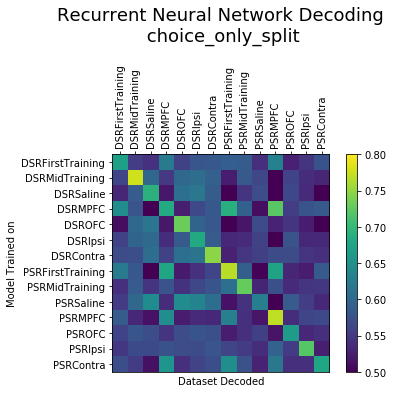

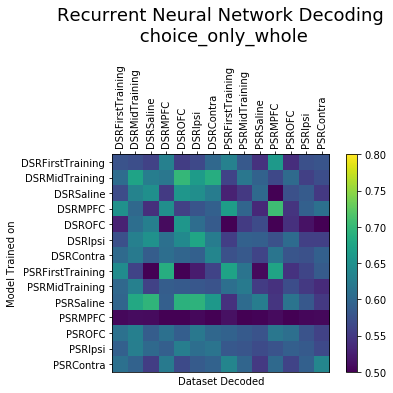

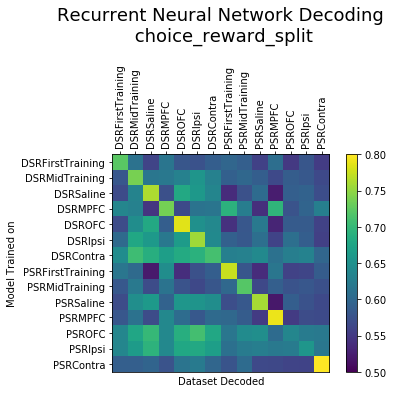

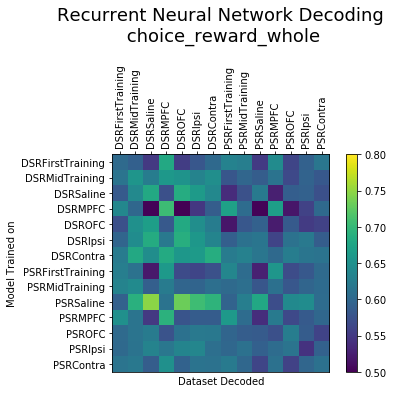

In [1]:
import pickle
import pandas as pd
import sys

ROOT = '/Users/pablomartin/python/'
sys.path.append(ROOT)
from Visualize.decoding import plot_model_grid


df = pickle.load(open( ROOT + '/DATA_structures/RNNgrid.p', 'rb'))

labels = [df.index.levels[0][a] + df.index.levels[1][b] \
             for a,b in zip(df.index.labels[0], df.index.labels[1])]

for info_included in ['choice_only', 'choice_reward']:
    for seq_type in ['split', 'whole']:
        input_seq = info_included + '_' + seq_type
        plot_model_grid(df[info_included, seq_type], [0.5, 0.8], 
            title = 'Recurrent Neural Network Decoding\n %s' %input_seq)

## Some Interpretations    

Some things to note right away is that there is a big difference in how we prepare the data. Breaking up the sessions into smaller "chunks" greatly improves performance of the model. Also, if we include information about the reward, as opposed to just using the choice, we get better decoding (look at diagonal). Neither of these things is surprising. Of course the information about reward is relevant. Also, "vanilla" RNNs are supposed to struggle with longer sequences and learning longer dependencies. So it is not surprising that if we fed the dataset "cut up" the models learned better.  

As for the data itself, the result of FirstTraining and MPFC predicting each other is barely there. I am looking only at choice_reward_split which corresponds to the third graph and the model with the best performance. Overall, decoding along the diagonal was not impressive either. Here are some next steps that come to mind:  

1) do some stat to see what models are "coupled" together  
2) train RNN for more epochs ? the error reduction for a lot of these was already asymptotic so pretty sure that wouldn't really help. EDIT: actually some of them look asymptotic but not all of them  
3) Explore where these networks are making their decoding mistakes.    
4) to do 3), unfortunately, we would have to retrain all the networks and split the data so as to leave entire sessions out, otherwise the test set is a bunch of small sequences from all over the place, and hard to tell where in the session it's going wrong. what patterns is it picking out ?  
5) to combine 2-4 and our conclusion that it was only the choice_reward_splits input sequence that was significantly better than the other we could do the following:    

Let's re-train everything with proper training and testing set separation, such that the testing set is taken from intact sessions that WE CAN VISUALIZE. Further, we can try higher batch number and bppt_truncate #, and *only* train with the data formatted as choice_reward_splits. We train 1/4 of the models but with greater depth.   

6) AND FINALLY, IF AND WHEN YOU DO THE POINTS ABOVE, THEN we may want to try fancier RNNs. Either "deep" ones, with more than one hidden layer, or long short-term memory (LSTM) ones


## Re-train Network with Greater Depth  

Main things to implement here are, proper data splitting and saving, so we don't have to rely on random seeds to know *how* the data was split.  

Train with greater depth and only one type of input sequence! What's greater depth here ? Since sequence length will be at most 50, since len(seq) ~ N(mu = 20, sigma = 7), we will set bptt_truncate to that. This means that the entire length of all sequences will be considered. The number of epochs will be doubled. Even that seems excessive as most errors were already plateauing, but let's try it anyways so we are not left with the doubt. AND the final element that can add depth to the network is the # of units of the hidden layer. Currently, it's set at 100. I haven't built enough intuition to know whether this is sufficient, although 100 things to learn about the sequences seems enough to me. We will also double this number so that we are left without a doubt and don't have to train the networks again. 

In [7]:
ROOT = '/Users/pablomartin/python'
source = ROOT + '/DATA_structures/RNN_sequences/'
target = ROOT + '/DATA_structures/RNN_models2/'

script_start = time.time()
for sequences in os.listdir(source):
    '''
    loading right dataset, i processed the split datasets elsewhere and saved them
    to the source folder we only care about 'choice_reward' and 'split' datasets that
    are already divided into training and testing sets for us
    '''
    task, regime, seq_type, seq_split = sequence_to_labels(sequences)
    
    if seq_type == 'choice_reward' \
    and seq_split == 'split' \
    and sequences.find('train') > 0:
    
        print '*' * 80
        print 'training RNN on %s - %s' %(task, regime)
        print '*' * 80

        x_train, y_train, x_test, y_test = pickle.load(open(source + sequences, 'rb'))
        elements_in_seq = 5

        #initialize RNN
        RNN = behaviorRNN(noFeatures = elements_in_seq, hidden_dim = 200, bptt_truncate = 50)    

        #train the network
        start = time.time()
        RNN.train_with_sgd(x_train, y_train, learning_rate = 0.005, nepoch = 200)
        print 'total training time: %1.2f minutes' %((time.time() - start)/60)
        save_model_parameters(target + sequences[:sequences.find('.')] + '.npz', RNN)
    

print 'total training time: %1.2f hours' %((time.time() - script_start) / 3600)

********************************************************************************
training RNN on PSR - MPFC
********************************************************************************
2018-06-27 00:19:24: Loss after num_examples_seen=0 epoch=0: 1.667220
2018-06-27 00:20:19: Loss after num_examples_seen=305 epoch=5: 0.958414
2018-06-27 00:21:13: Loss after num_examples_seen=610 epoch=10: 0.942054
2018-06-27 00:22:07: Loss after num_examples_seen=915 epoch=15: 0.984904
Setting learning rate to 0.002500
2018-06-27 00:23:01: Loss after num_examples_seen=1220 epoch=20: 0.755833
2018-06-27 00:23:55: Loss after num_examples_seen=1525 epoch=25: 0.730143
2018-06-27 00:24:49: Loss after num_examples_seen=1830 epoch=30: 0.564398
2018-06-27 00:25:42: Loss after num_examples_seen=2135 epoch=35: 1.172298
Setting learning rate to 0.001250
2018-06-27 00:26:36: Loss after num_examples_seen=2440 epoch=40: 0.906746
2018-06-27 00:27:31: Loss after num_examples_seen=2745 epoch=45: 0.872210
2018-06-27 

2018-06-27 01:10:49: Loss after num_examples_seen=2880 epoch=60: 1.186851
2018-06-27 01:11:20: Loss after num_examples_seen=3120 epoch=65: 1.127247
2018-06-27 01:11:51: Loss after num_examples_seen=3360 epoch=70: 1.092265
2018-06-27 01:12:22: Loss after num_examples_seen=3600 epoch=75: 1.174236
Setting learning rate to 0.000625
2018-06-27 01:12:53: Loss after num_examples_seen=3840 epoch=80: 1.004690
2018-06-27 01:13:24: Loss after num_examples_seen=4080 epoch=85: 0.977277
2018-06-27 01:13:55: Loss after num_examples_seen=4320 epoch=90: 0.955828
2018-06-27 01:14:26: Loss after num_examples_seen=4560 epoch=95: 0.937133
2018-06-27 01:14:57: Loss after num_examples_seen=4800 epoch=100: 0.921987
2018-06-27 01:15:28: Loss after num_examples_seen=5040 epoch=105: 0.906544
2018-06-27 01:15:59: Loss after num_examples_seen=5280 epoch=110: 0.891794
2018-06-27 01:16:31: Loss after num_examples_seen=5520 epoch=115: 0.878509
2018-06-27 01:17:01: Loss after num_examples_seen=5760 epoch=120: 0.864250

2018-06-27 02:07:33: Loss after num_examples_seen=6075 epoch=135: 0.527895
2018-06-27 02:07:59: Loss after num_examples_seen=6300 epoch=140: 0.517881
2018-06-27 02:08:26: Loss after num_examples_seen=6525 epoch=145: 0.510808
2018-06-27 02:08:53: Loss after num_examples_seen=6750 epoch=150: 0.498349
2018-06-27 02:09:19: Loss after num_examples_seen=6975 epoch=155: 0.489094
2018-06-27 02:09:46: Loss after num_examples_seen=7200 epoch=160: 0.489405
Setting learning rate to 0.000313
2018-06-27 02:10:13: Loss after num_examples_seen=7425 epoch=165: 0.466818
2018-06-27 02:10:39: Loss after num_examples_seen=7650 epoch=170: 0.460382
2018-06-27 02:11:06: Loss after num_examples_seen=7875 epoch=175: 0.454428
2018-06-27 02:11:32: Loss after num_examples_seen=8100 epoch=180: 0.448378
2018-06-27 02:11:59: Loss after num_examples_seen=8325 epoch=185: 0.442070
2018-06-27 02:12:26: Loss after num_examples_seen=8550 epoch=190: 0.435484
2018-06-27 02:12:52: Loss after num_examples_seen=8775 epoch=195: 

2018-06-27 04:15:00: Loss after num_examples_seen=250 epoch=5: 0.724324
2018-06-27 04:15:33: Loss after num_examples_seen=500 epoch=10: 0.738812
Setting learning rate to 0.002500
2018-06-27 04:16:07: Loss after num_examples_seen=750 epoch=15: 0.630588
2018-06-27 04:16:41: Loss after num_examples_seen=1000 epoch=20: 0.653030
Setting learning rate to 0.001250
2018-06-27 04:17:16: Loss after num_examples_seen=1250 epoch=25: 0.461590
2018-06-27 04:17:50: Loss after num_examples_seen=1500 epoch=30: 0.415531
2018-06-27 04:18:24: Loss after num_examples_seen=1750 epoch=35: 0.387788
2018-06-27 04:18:57: Loss after num_examples_seen=2000 epoch=40: 0.342254
2018-06-27 04:19:32: Loss after num_examples_seen=2250 epoch=45: 0.313721
2018-06-27 04:20:06: Loss after num_examples_seen=2500 epoch=50: 0.298592
2018-06-27 04:20:40: Loss after num_examples_seen=2750 epoch=55: 0.234780
2018-06-27 04:21:13: Loss after num_examples_seen=3000 epoch=60: 0.196665
2018-06-27 04:21:47: Loss after num_examples_see

2018-06-27 05:26:06: Loss after num_examples_seen=4560 epoch=80: 0.458644
2018-06-27 05:26:59: Loss after num_examples_seen=4845 epoch=85: 0.454508
2018-06-27 05:27:51: Loss after num_examples_seen=5130 epoch=90: 0.546524
Setting learning rate to 0.000313
2018-06-27 05:28:44: Loss after num_examples_seen=5415 epoch=95: 0.497541
2018-06-27 05:29:36: Loss after num_examples_seen=5700 epoch=100: 0.491742
2018-06-27 05:30:28: Loss after num_examples_seen=5985 epoch=105: 0.487904
2018-06-27 05:31:21: Loss after num_examples_seen=6270 epoch=110: 0.481506
2018-06-27 05:32:13: Loss after num_examples_seen=6555 epoch=115: 0.478647
2018-06-27 05:33:06: Loss after num_examples_seen=6840 epoch=120: 0.477621
2018-06-27 05:33:58: Loss after num_examples_seen=7125 epoch=125: 0.476238
2018-06-27 05:34:51: Loss after num_examples_seen=7410 epoch=130: 0.469886
2018-06-27 05:35:43: Loss after num_examples_seen=7695 epoch=135: 0.466279
2018-06-27 05:36:36: Loss after num_examples_seen=7980 epoch=140: 0.46

2018-06-27 06:23:05: Loss after num_examples_seen=5920 epoch=160: 0.075114
2018-06-27 06:23:23: Loss after num_examples_seen=6105 epoch=165: 0.074587
2018-06-27 06:23:41: Loss after num_examples_seen=6290 epoch=170: 0.074100
2018-06-27 06:23:59: Loss after num_examples_seen=6475 epoch=175: 0.073647
2018-06-27 06:24:17: Loss after num_examples_seen=6660 epoch=180: 0.073225
2018-06-27 06:24:36: Loss after num_examples_seen=6845 epoch=185: 0.072831
2018-06-27 06:24:54: Loss after num_examples_seen=7030 epoch=190: 0.072461
2018-06-27 06:25:12: Loss after num_examples_seen=7215 epoch=195: 0.072114
total training time: 12.09 minutes
Saved model parameters to /Users/pablomartin/python/DATA_structures/RNN_models2/DSRMidTraining_choice_reward_split_sequences_train_test.npz.
********************************************************************************
training RNN on DSR - Saline
********************************************************************************
2018-06-27 06:25:30: Loss after n

In [28]:
import pandas as pd

def mod_test_sequences(model_dir, sequence_dir, sequences, sequences2):
    
    #loading previously trained model
    RNN = behaviorRNN()
    model_file = sequences[:sequences.find('.')] + '.npz' 
    load_model_parameters(model_dir + model_file, RNN)
    #loading appropriate dataset
    tmp_seq = sequences2[:sequences2.find('.')] + '.p'     
    x_train, y_train, x_test, y_test = pickle.load(open(sequence_dir + tmp_seq, 'rb'))

    
    #checking accuracy
    hits = 0
    trials = 0
    for test_seq in x_test:
        out = evaluate_model(test_seq, 'choice_reward', RNN)
        hits += out[0]
        trials += out[1]
            
    return float(hits)/trials

finished: PSR - MPFC - choice_reward - split
time elapsed: 0.32 minutes
finished: DSR - FirstTraining - choice_reward - split
time elapsed: 0.31 minutes
finished: PSR - MidTraining - choice_reward - split
time elapsed: 0.31 minutes
finished: PSR - Ipsi - choice_reward - split
time elapsed: 0.31 minutes
finished: DSR - OFC - choice_reward - split
time elapsed: 0.32 minutes
finished: PSR - OFC - choice_reward - split
time elapsed: 0.32 minutes
finished: PSR - Saline - choice_reward - split
time elapsed: 0.31 minutes
finished: DSR - Ipsi - choice_reward - split
time elapsed: 0.31 minutes
finished: PSR - Contra - choice_reward - split
time elapsed: 0.31 minutes
finished: DSR - MPFC - choice_reward - split
time elapsed: 0.33 minutes
finished: DSR - Contra - choice_reward - split
time elapsed: 0.34 minutes
finished: DSR - MidTraining - choice_reward - split
time elapsed: 0.33 minutes
finished: DSR - Saline - choice_reward - split
time elapsed: 0.32 minutes
finished: PSR - FirstTraining - cho

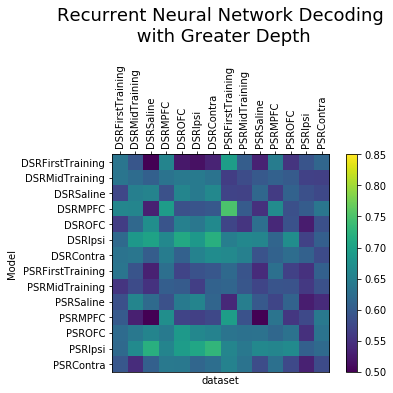

In [30]:
sequence_dir = ROOT + '/DATA_structures/RNN_sequences/'
model_dir = ROOT + '/DATA_structures/RNN_models2/'

#creating dataframe
idx = pd.IndexSlice
iterables_row = [['DSR','PSR'], ['FirstTraining', 'MidTraining', 'Saline',
                                 'MPFC', 'OFC', 'Ipsi', 'Contra']]
row_index  = pd.MultiIndex.from_product(iterables_row, names=['task','regime'])
df = pd.DataFrame(np.full([len(row_index),len(row_index)], np.NaN),
                                                      index = row_index,
                                                      columns=row_index)



for sequences in os.listdir(sequence_dir):
    
    task, regime, seq_type, seq_split = sequence_to_labels(sequences)
    
    #only taking input sequences that have been split into training and test sets
    if sequences.find('train') > 0\
    and seq_type == 'choice_reward'\
    and seq_split == 'split':
        start = time.time()
        for comparator in os.listdir(sequence_dir):
            
            task2, regime2, seq_type2, seq_split2  = sequence_to_labels(comparator)
            
            #only working within input sequence type
            if comparator.find('train') > 0 \
            and seq_split2 == 'split' \
            and seq_type2 == 'choice_reward':
                df.loc[idx[task, regime], idx[task2, regime2]] = \
                        mod_test_sequences(model_dir, sequence_dir, sequences, comparator)

            
            
        print 'finished: %s - %s - %s - %s' %(task, regime, seq_type, seq_split)
        print 'time elapsed: %1.2f minutes' %((time.time() - start) / 60)
    

labels = [df.index.levels[0][a] + df.index.levels[1][b] \
             for a,b in zip(df.index.labels[0], df.index.labels[1])]

plot_models(df, labels, 'Recurrent Neural Network Decoding\n with Greater Depth', [0.5, 0.85] )

WTF. Double the hidden units and training epochs resulted in worse decoding. Barring an error ? Not sure what happened here. 